Prepping the PBMC data.

Following scanpy tutorial:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
    
## INPUT: 

 * NONE.

## OUTPUT: 

 * data/test_data/pmbc.h5ad
 
## Environment Setup

In [2]:
os.getcwd()

'/Users/uqbbalde/Desktop/Uni_Studies/projects/Cytocipher_manuscript/scripts/X1_pbmc3k'

In [6]:
work_dir = '../../' # Put path to where installed Cytocipher_manuscript github repo.
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

out_dir = 'data/test_data/'

## Downloading the data

In [3]:
os.system(f'mkdir {out_dir}')
os.system(f'wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O {out_dir}pbmc3k_filtered_gene_bc_matrices.tar.gz')
os.system(f'cd {out_dir}; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz')
os.chdir(work_dir)

mkdir: data/test_data/: File exists
--2022-07-31 09:20:31--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-07-31 09:20:32--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/test_data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  209K 35s
    50K .......... .......... .......... .......... .

0

In [6]:
os.system(f'ls {out_dir}')

filtered_gene_bc_matrices
pbmc3k_filtered_gene_bc_matrices.tar.gz


0

In [7]:
data = sc.read_10x_mtx(
    f'{out_dir}filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [8]:
data.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

## Running through the preprocessing...

In [9]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

In [10]:
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
print(data.shape)
data = data[data.obs.n_genes_by_counts < 2500, :]
data = data[data.obs.pct_counts_mt < 5, :]
data.shape

(2700, 13714)


(2638, 13714)

## Cacheing counts, normalising, clustering, labelling, saving the .h5ad!

In [13]:
data.layers['counts'] = data.X
data.layers['counts']

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [14]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

In [15]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

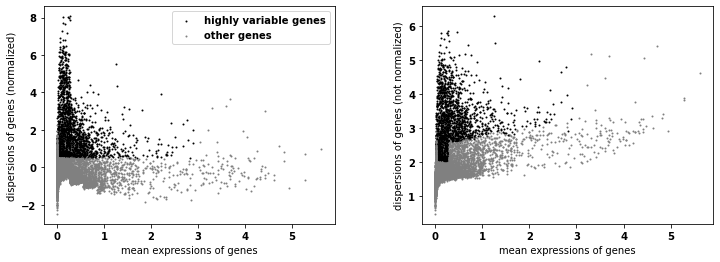

In [16]:
sc.pl.highly_variable_genes(data)

In [17]:
sc.tl.pca(data, svd_solver='arpack')

In [18]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)

In [20]:
sc.tl.umap(data)

In [36]:
sc.tl.leiden(data, resolution=.7)

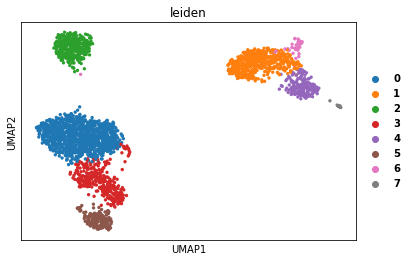

In [38]:
sc.pl.umap(data, color='leiden')

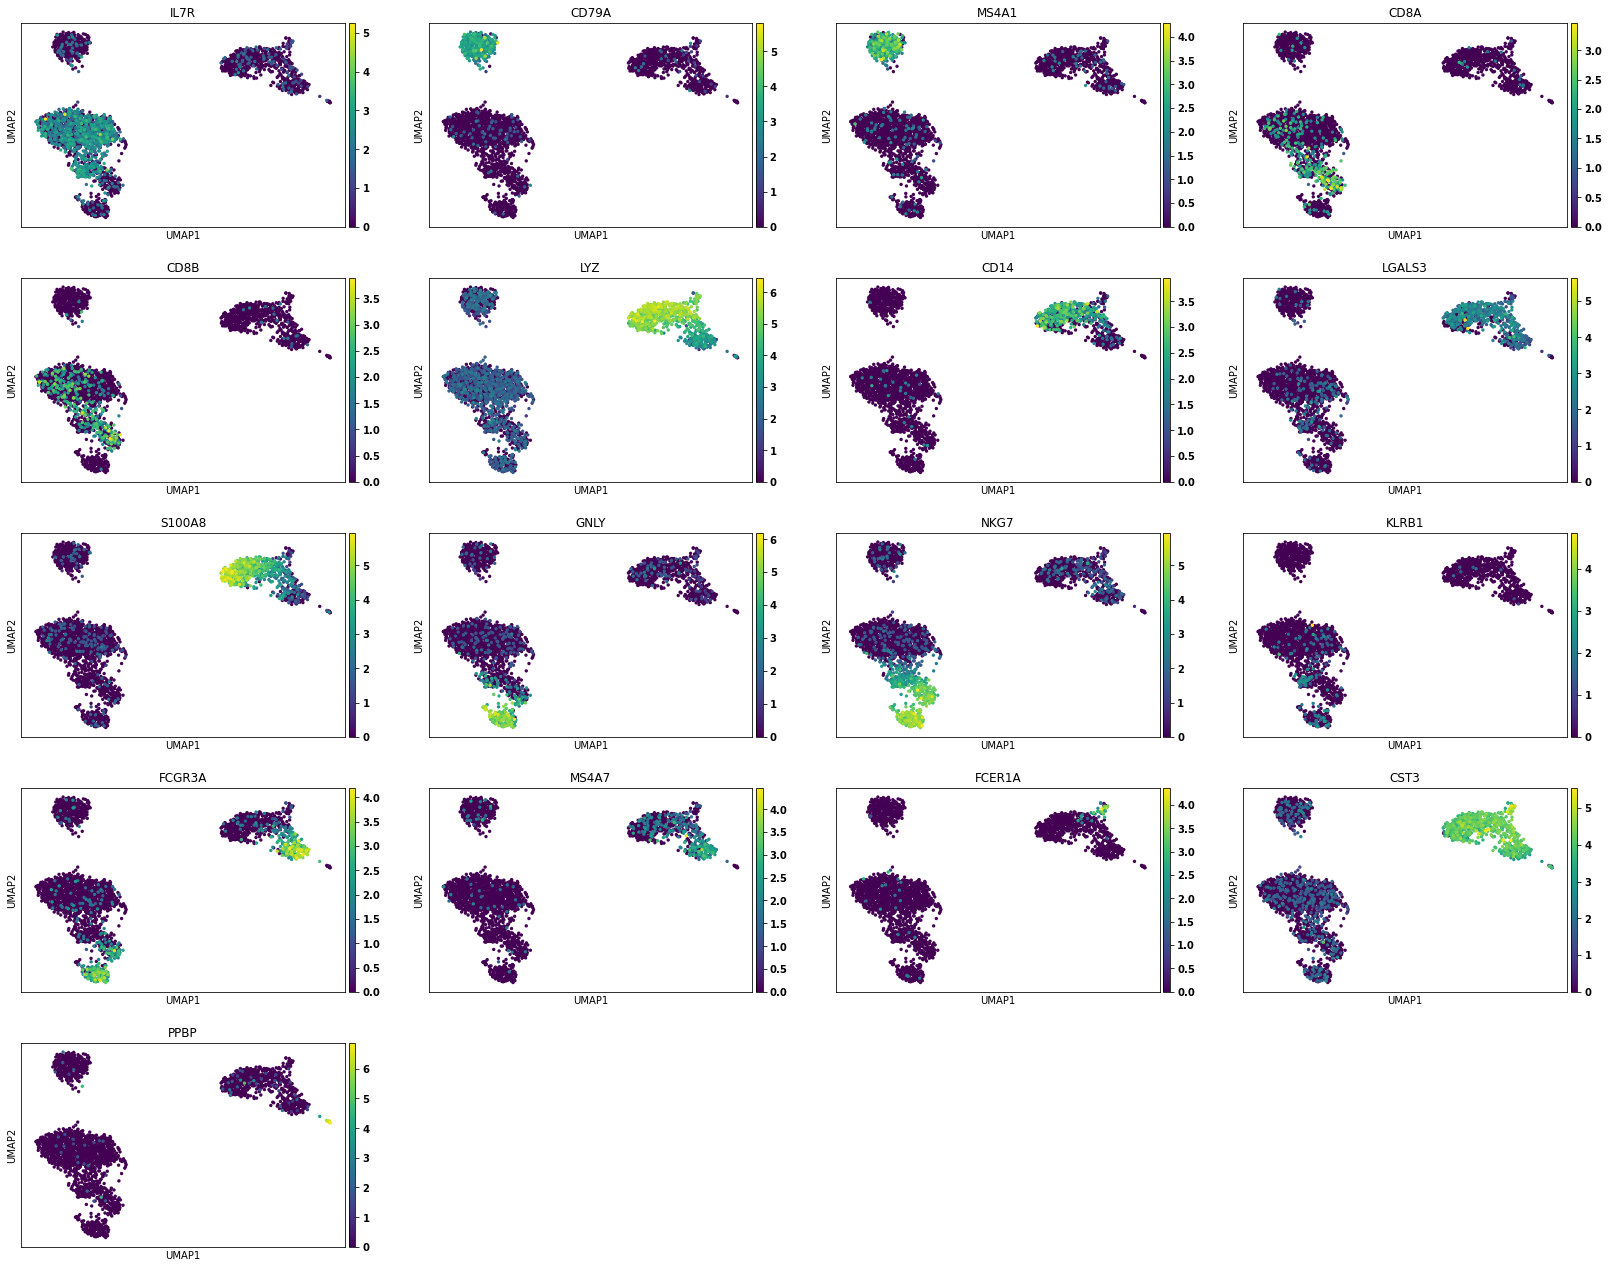

In [23]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

sc.pl.umap(data, color=marker_genes)

In [39]:
print(data.obs['leiden'].cat.categories)

Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')


In [40]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
data.rename_categories('leiden', new_cluster_names)

/Users/uqbbalde/opt/miniconda3/envs/hypo_atlas/lib/python3.8/site-packages/anndata/_core/anndata.py:1163: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


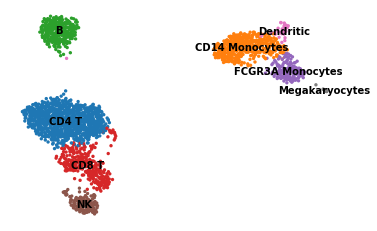

In [41]:
sc.pl.umap(data, color='leiden', legend_loc='on data', title='', frameon=False)

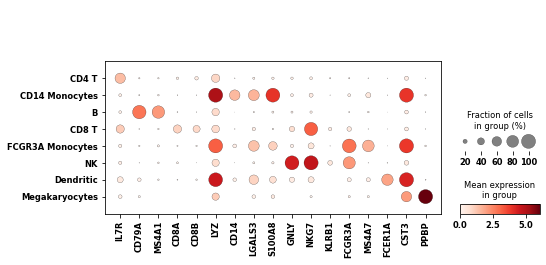

In [42]:
sc.pl.dotplot(data, marker_genes, groupby='leiden');

In [44]:
data.layers['counts']

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [46]:
data.layers['counts'] = data.layers['counts'].toarray()

## Looks identical to the tutorial!!! Saving the output.

In [49]:
data.write_h5ad(out_dir+'pbmc.h5ad', compression='gzip')

In [48]:
out_dir

'data/test_data/'